This file also contains the EDA and Preprocessing, but since this came after doing the other attempts, and it has overall lower correlation with data, we decided that only one locations should suffice.

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from collections import Counter

from sklearn.model_selection import train_test_split,cross_validate, learning_curve, GridSearchCV,RepeatedStratifiedKFold
#imported scalers but for decision trees they are realtively uneccessary.
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score,accuracy_score
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from hyperopt import STATUS_OK,Trials, fmin, hp, tpe

In [106]:
#this was used to randomize the data as it was made by just adding one of wine files to the end of the other
"""
total_wine = pd.read_csv("data/winequality-total.csv", delimiter=";")
total = total_wine.sample(frac=1)
total_wine.to_csv("data/winequality-total.csv")
"""

'\ntotal_wine = pd.read_csv("data/winequality-total.csv", delimiter=";")\ntotal = total_wine.sample(frac=1)\ntotal_wine.to_csv("data/winequality-total.csv")\n'

In [107]:
total_wine = pd.read_csv("data/winequality-total.csv",index_col=0)

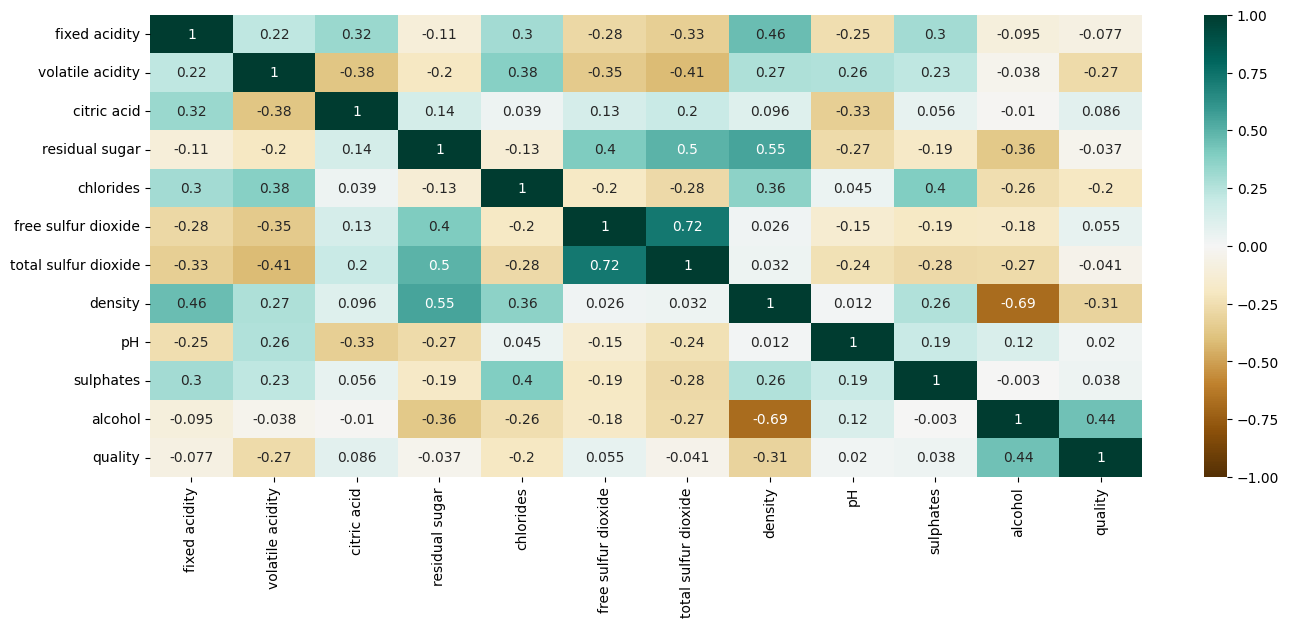

In [108]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(total_wine.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

The only valuable ones that seem to be present: alcohol, volatile aciditiy, chlorides, and density. However, to maintain consistence, and to also test the effectiveness of correlation analysis, we will drop the same ones we did for the xgboost implmentation on only red wine. Granted, the dynamics do change with the entence of white wine, but if the accuracy is at least comparable, we can investigate later.

In [109]:
total_wine = total_wine.drop(["residual sugar","pH", "free sulfur dioxide"], axis=1)

---
Alcohol

In [110]:
fig = make_subplots(rows=2,cols=2)

#histogram for red
fig.append_trace(go.Histogram(
    x=total_wine["alcohol"],
    name="red hist"), row=1,col=1)

#boxplot for red
fig.append_trace(go.Box(
    x=total_wine["alcohol"],
    name="red box"
),row=1,col=2)

fig.append_trace(go.Box(
    x=total_wine["quality"],
    y=total_wine["alcohol"],
    name="quality/alcohol"
),row=2, col=1)

#histogram for white
fig.update_layout(height=600, width=1200, title_text="Alochol data")
fig.show()

Allmost the same as what was seen ealier in red_wine. Therefore, going to treat it about the same

---
Volatile acidity

In [111]:
fig = make_subplots(rows=2,cols=2)

#histogram for red
fig.append_trace(go.Histogram(
    x=total_wine["volatile acidity"],
    name="normal hist"), row=1,col=1)

#boxplot for red
fig.append_trace(go.Box(
    x=total_wine["volatile acidity"],
    name="normal box"
),row=1,col=2)

fig.append_trace(go.Box(
    x=total_wine["quality"],
    y=total_wine["volatile acidity"],
    name="quality/alcohol"
),row=2, col=1)

#histogram for white
fig.update_layout(height=600, width=1200, title_text="VA data")
fig.show()

Extremely right skewed, can be adjusted later if necessary, but it seems that the lower the value goes the more likely it is high quality, but not a strong indicator

---
Density

In [112]:
fig = make_subplots(rows=2,cols=2)

#histogram for red
fig.append_trace(go.Histogram(
    x=total_wine["density"],
    name="normal hist"), row=1,col=1)

#boxplot for red
fig.append_trace(go.Box(
    x=total_wine["density"],
    name="normal box"
),row=1,col=2)

fig.append_trace(go.Box(
    x=total_wine["quality"],
    y=total_wine["density"],
    name="quality/density"
),row=2, col=1)

#histogram for white
fig.update_layout(height=600, width=1200, title_text="density data")
fig.show()

Should drop that outlier but follow a similar trend to VA, where the values tend to decrease. Additionally, it apppears to still be a shaky, but still gaussian distribution.

---
Chlorides

In [113]:
fig = make_subplots(rows=2,cols=2)

#histogram for red
fig.append_trace(go.Histogram(
    x=total_wine["chlorides"],
    name="normal hist"), row=1,col=1)

#boxplot for red
fig.append_trace(go.Box(
    x=total_wine["chlorides"],
    name="normal box"
),row=1,col=2)

fig.append_trace(go.Box(
    x=total_wine["quality"],
    y=total_wine["chlorides"],
    name="quality/chlorides"
),row=2, col=1)

#histogram for white
fig.update_layout(height=600, width=1200, title_text="chlorides data")
fig.show()

Very far skew, but it seems relevent. The 

---
Preprocessing

In [114]:
def remove_outliers(df: pd.DataFrame, n :float, columns):
    #this is the Tukey method which gets the values that exists outside of the outer fence of a histogram of a particular value
    #This is valuale if outliers effect the data alot (typically regression), in classification this might be different
    #Classifiaction in imbalanced datasets (like this one), might need outliers, so I am going to try with both

    total_outliers = []

    for col in columns:

        #generating the quantile ranges that will be used to determine outliers
        q1 = df[col].quantile(.25)
        q3 = df[col].quantile(.75)

        iqr = q3 - q1
        outer_fence = iqr * 1.5

        outliers = df[(df[col] < q1 - outer_fence) | (df[col] > q3 + outer_fence)].index

        total_outliers.extend(outliers)

    #select the indexes (tuples) that have more than n attributes that are outliers (can scale)
    outliers = Counter(total_outliers)
    multiple_outliers = list(k for k , v in outliers.items() if v > n)


    return multiple_outliers


In [115]:
len(total_wine)

6497

In [116]:
#finding all outliers that have significant outliers 
outliers = remove_outliers(total_wine,2,total_wine.columns[:-1])
total_wine = total_wine.drop(outliers, axis=0).reset_index(drop=True)
len(total_wine)

6432

Didn't lose any by checking if there was more than one column having outliers per tuple so it seems relativley ok to go ahead and remove 1. Ended up with 70 which is good

---
Training Model

In [117]:
X_train = total_wine.drop("quality" , axis=1)
y_train = total_wine["quality"]
X_test = total_wine.drop("quality" , axis=1).copy()
y_test = total_wine["quality"]

In [118]:
y_train = y_train.map({3: 0, 4: 1, 5:2, 6:3, 7:4, 8:5, 9:6})
y_test = y_test.map({3: 0, 4: 1, 5:2, 6:3, 7:4, 8:5, 9:6})

In [119]:
space = {"max_depth":hp.quniform("max_depth",3,18,1),
         "gamma" : hp.uniform('gamma',1,9),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=total_wine["quality"]
)

In [120]:
def ojective(space:dict):
        #creating a classifer with the opametrs pulled from the space that has been already been listed. 
        #Most explanation is above
        clf=XGBClassifier(
                n_estimators =space['n_estimators'],
                max_depth = int(space['max_depth']),
                gamma = space['gamma'],
                min_child_weight=int(space['min_child_weight']),
                colsample_bytree=int(space['colsample_bytree']),
                objective="multi:softprob",
                early_stopping_rounds=10,
                eval_metric="auc")

        #evalutation train set and test set for doing a fit, efficivly measuring against the test like a normal accuracy measure would
        evaluation = [( X_train, y_train), ( X_test, y_test)]

        clf.fit(X_train,y_train,eval_set=evaluation,
                verbose=False,
                sample_weight=classes_weights)
        

        y_pred = clf.predict(X_test)
        #
        accuracy = f1_score(y_test,y_pred,average="micro")
        print("SCORE:" + str(accuracy))
        return {'loss' : -accuracy, "status" : STATUS_OK}

In [121]:
trials = Trials()


best_hyperparams = fmin(fn = ojective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

SCORE:0.41480099502487555                             
SCORE:0.38044154228855714                                                         
SCORE:0.3599191542288557                                                          
SCORE:0.449160447761194                                                           
SCORE:0.3622512437810946                                                          
SCORE:0.42879353233830847                                                       
SCORE:0.42739427860696516                                                       
SCORE:0.4964241293532338                                                        
SCORE:0.5491293532338308                                                         
SCORE:0.3865049751243781                                                         
SCORE:0.4076492537313433                                                          
SCORE:0.3843283582089552                                                          
SCORE:0.4141791044776119                

In [124]:
best_hyperparams ={'colsample_bytree': 0.7301681965337306,
 'gamma': 1.138840650666901,
 'max_depth': 14.0,
 'min_child_weight': 3.0}

In [122]:
accuracies = []
for i in range(0,5):
    model=XGBClassifier(
        n_estimators=180, 
        max_depth = int(best_hyperparams['max_depth']),
        gamma = best_hyperparams['gamma'],
        min_child_weight=int(best_hyperparams['min_child_weight']),
        colsample_bytree=int(best_hyperparams['colsample_bytree']),
        objective="mult:softprob",
        eval_metric="auc",
        seed=i)


    model.fit(X_train, 
              y_train,
              verbose=False)

    y_pred = model.predict(X_test)

    accuracies.append(f1_score(y_test,y_pred,average="micro"))

accuracies

[0.665889303482587,
 0.6635572139303483,
 0.6630907960199005,
 0.665889303482587,
 0.6672885572139303]

In [125]:
average = np.mean(accuracies)
average

0.6651430348258706

Conclusion(s)

correlational anaylisis has a limit. Possibly, we could use clustering algorithms, or other types of EDA to try and find more meaningful connections

Performance between two

how much is effected from doin a multilabel vs. a binary (just look online for another study)